[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/examples/simulation_example_Gaussian.ipynb)

# Imports

In [1]:
# !pip install git+https://github.com/StatMixedML/XGBoostLSS.git

In [ ]:
import numpy as np
import pandas as pd
import pkg_resources
import itertools
import shap
import math
import multiprocessing
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotnine
from plotnine import aes, element_text, geom_line, geom_point, geom_step, ggplot, labs, theme, theme_bw
plotnine.options.figure_size = (20, 10)

from xgboostlss.model import xgboostlss, xgb
from xgboostlss.distributions.Gaussian import Gaussian
from xgboostlss.datasets.data_loader import load_simulated_data

In [ ]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_data()
n_cpu = multiprocessing.cpu_count()

y_col = "y"
x_cols = [col for col in train.columns if col != y_col]

X_train = train.loc[:, x_cols]
y_train = train.loc[:, y_col]

X_test = test.loc[:, x_cols]
y_test =test.loc[:, y_col]

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Data

# Distribution and Quantile Selection

In [4]:
distribution = Gaussian                   # Estimates both location and scale parameters of the Gaussian simultaneously.
distribution.stabilize = "None"           # Option to stabilize Gradient/Hessian. Options are "None", "MAD", "L2"
quant_sel = [0.05, 0.95]
seed = 123

# Hyper-Parameter Optimization

In [5]:
# define xgboost hyperparameter
n_rounds = 315
params = {'eta': 0.8238,
            'max_depth': 2,
            'gamma': 23.8128,
            'subsample': 0.8692,
            'colsample_bytree': 0.5845,
            'min_child_weight': 194}


In [6]:
# set `optimize_hyper_params` to True if you want to see the hyper parameter optimization
optimize_hyper_params = False

if optimize_hyper_params:
    np.random.seed(seed)

    # Specifies the parameters and their value range. The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]. Currently, only the following hyper-parameters can be optimized:
    params = {"eta": [1e-5, 1],                   
              "max_depth": [1, 10],
              "gamma": [1e-8, 40],
              "subsample": [0.2, 1.0],
              "colsample_bytree": [0.2, 1.0],
              "min_child_weight": [0, 500]
             }

    opt_params = xgboostlss.hyper_opt(params,
                                      dtrain=dtrain,
                                      dist=distribution,
                                      num_boost_round=500,       # Number of boosting iterations.
                                      max_minutes=120,           # Time budget in minutes, i.e., stop study after the given number of minutes.
                                      n_trials=None,             # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                      silence=False)             # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

    print(opt_params)
    n_rounds = opt_params["opt_rounds"]
    _ = opt_params.pop("opt_rounds")
    params = opt_params


# Model Training


In [7]:
np.random.seed(seed)

# Train Model with optimized hyper-parameters
xgboostlss_model = xgboostlss.train(params,
                                    dtrain,
                                    dist=distribution,
                                    num_boost_round=n_rounds,
                                    )

# Prediction

In [8]:
# Number of samples to draw from predicted distribution
n_samples=10000

# Using predicted distributional parameters, sample from distribution
pred_y = xgboostlss.predict(xgboostlss_model, 
                            dtest, 
                            dist=distribution,
                            pred_type="response",
                            n_samples=n_samples, 
                            seed=seed)

# Using predicted distributional parameters, calculate quantiles
pred_quantiles = xgboostlss.predict(xgboostlss_model, 
                                    dtest, 
                                    dist=distribution,
                                    pred_type="quantiles", 
                                    quantiles=quant_sel, 
                                    seed=seed)


# Returns predicted distributional parameters
pred_params = xgboostlss.predict(xgboostlss_model, 
                                 dtest, 
                                 dist=distribution,
                                 pred_type="parameters")

In [9]:
pred_y.head()

,y_pred_sample_0,y_pred_sample_1,y_pred_sample_2,y_pred_sample_3,y_pred_sample_4,y_pred_sample_5,y_pred_sample_6,y_pred_sample_7,y_pred_sample_8,y_pred_sample_9,...,y_pred_sample_9990,y_pred_sample_9991,y_pred_sample_9992,y_pred_sample_9993,y_pred_sample_9994,y_pred_sample_9995,y_pred_sample_9996,y_pred_sample_9997,y_pred_sample_9998,y_pred_sample_9999
0,6.892923,12.871753,10.821284,5.685478,8.348268,14.749211,3.043670,8.777921,13.642697,7.521210,...,6.964368,6.320441,13.083898,15.494050,11.872379,8.292821,5.996516,8.653481,11.679472,12.795022
1,6.892923,12.871753,10.821284,5.685478,8.348268,14.749211,3.043670,8.777921,13.642697,7.521210,...,6.964368,6.320441,13.083898,15.494050,11.872379,8.292821,5.996516,8.653481,11.679472,12.795022
2,8.909650,11.019029,10.295607,8.483654,9.423107,11.681412,7.551603,9.574692,11.291025,9.131315,...,8.934857,8.707674,11.093876,11.944197,10.666442,9.403545,8.593390,9.530789,10.598383,10.991958
3,4.978088,14.630871,11.320401,3.028676,7.327733,17.662014,-1.236506,8.021405,15.875556,5.992454,...,5.093436,4.053819,14.973377,18.864553,13.017387,7.238214,3.530844,7.820498,12.705941,14.506988
4,6.892923,12.871753,10.821284,5.685478,8.348268,14.749211,3.043670,8.777921,13.642697,7.521210,...,6.964368,6.320441,13.083898,15.494050,11.872379,8.292821,5.996516,8.653481,11.679472,12.795022


In [10]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,5.287768,14.730315
1,5.287768,14.730315
2,8.343338,11.674745
3,2.386575,17.631508
4,5.287768,14.730315


# Plot of Actual vs. Predicted Quantiles

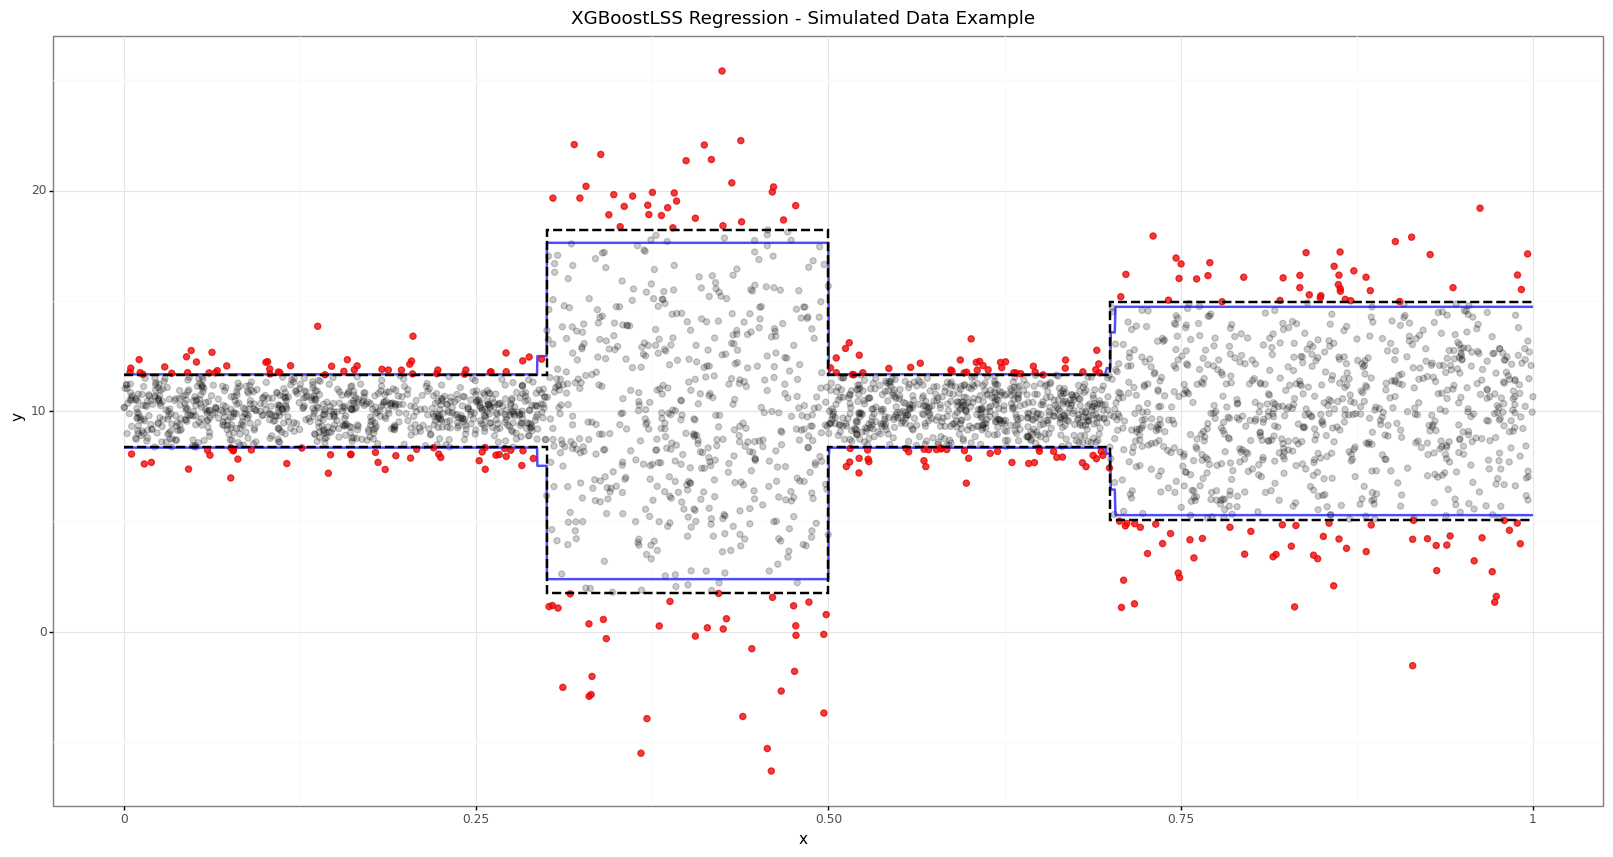

<ggplot: (8749578078717)>

In [11]:
np.random.seed(seed)

###
# Actual Quantiles
###
q1 = norm.ppf(quant_sel[0], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
q2 = norm.ppf(quant_sel[1], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
test["quant"] = np.where(test["y"].values < q1, 0, np.where(test["y"].values < q2, 1, 2))
test["alpha"] = np.where(test["y"].values <= q1, 1, np.where(test["y"].values >= q2, 1, 0))
df_quantiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(q1))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(q2))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Quantiles
###
test["lb"] = pred_quantiles.iloc[:,0]
test["ub"] = pred_quantiles.iloc[:,1]



###
# Plot
### ggplot, aes, geom_point, theme_bw, element_text, labs, geom_line, geom_step
(ggplot(test,
        aes("x",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw() + 
 theme(
     legend_position="right",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "XGBoostLSS Regression - Simulated Data Example")  + 
 geom_line(aes("x",
               "ub"),
           size = 1,
           color = "blue", 
           alpha = 0.7
           , show_legend=True) + 
 geom_line(aes("x",
               "lb"),
           size = 1,
           color = "blue", 
           alpha = 0.7
           , show_legend=True) + 
 geom_point(df_quantiles,
            aes("x",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed")
)

# SHAP Interpretability


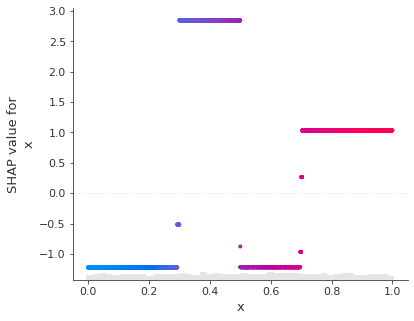

In [12]:
# Partial Dependence Plot of how x acts on variance 
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale",
                feature="x", 
                plot_type="Partial_Dependence")

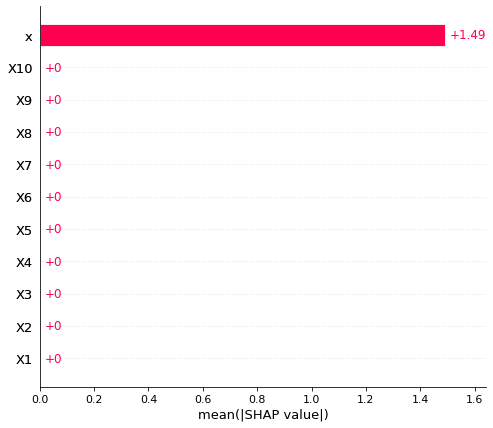

In [13]:
# Feature Importance of features on scale parameter
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale", 
                plot_type="Feature_Importance")